In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import calendar
import warnings
warnings.filterwarnings("ignore")

df_1 = pd.read_csv("202201-divvy-tripdata.csv")
df_2 = pd.read_csv("202202-divvy-tripdata.csv")
df_3 = pd.read_csv("202203-divvy-tripdata.csv")
df_4 = pd.read_csv("202204-divvy-tripdata.csv")
df_5 = pd.read_csv("202205-divvy-tripdata.csv")
df_6 = pd.read_csv("202206-divvy-tripdata.csv")
df_7 = pd.read_csv("202207-divvy-tripdata.csv")
df_8 = pd.read_csv("202208-divvy-tripdata.csv")
df_9 = pd.read_csv("202209-divvy-tripdata.csv")
df_10 = pd.read_csv("202210-divvy-tripdata.csv")
df_11 = pd.read_csv("202211-divvy-tripdata.csv")
df_12 = pd.read_csv("202212-divvy-tripdata.csv")

### Drop the null values and convert _started_at_ and _ended_at_ features into datetime

In [2]:
trip_data= [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12]

for df in trip_data:
    df.dropna(inplace=True)
    df["started_at"] = pd.to_datetime(df["started_at"])
    df["ended_at"] = pd.to_datetime(df["ended_at"])

    df.reset_index(inplace=True)
    df.drop(columns="index", inplace=True)

### Add columns _ride_length_ and _day_of_week_

In [3]:
conn=sql.connect("Cyclistic.db")
months=calendar.month_name[1:]

for df,month in zip(trip_data, months):
    df["ride_length"] = df["ended_at"] - df["started_at"]
    df["ride_length"] = df["ride_length"].dt.seconds

    df["day_of_week"] = df["started_at"].dt.day_name()

### Clean the data frames and create tables of each month using sqlite3 

In [4]:
for df,month in zip(trip_data, months):
    lst=[]
    for i,d in enumerate(df.values):
        if d[13] ==0:
            lst.append(i)
        elif d[2] > d[3]:
            start=d[2]
            end=d[3]
            df["started_at"][i]=end
            df["ended_at"][i]=start
        else:
            continue
        
    df.drop(lst, inplace=True)
    df.to_sql(month, con=conn, if_exists="replace", index=False)

In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80128 entries, 0 to 80127
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ride_id             80128 non-null  object        
 1   rideable_type       80128 non-null  object        
 2   started_at          80128 non-null  datetime64[ns]
 3   ended_at            80128 non-null  datetime64[ns]
 4   start_station_name  80128 non-null  object        
 5   start_station_id    80128 non-null  object        
 6   end_station_name    80128 non-null  object        
 7   end_station_id      80128 non-null  object        
 8   start_lat           80128 non-null  float64       
 9   start_lng           80128 non-null  float64       
 10  end_lat             80128 non-null  float64       
 11  end_lng             80128 non-null  float64       
 12  member_casual       80128 non-null  object        
 13  ride_length         80128 non-null  int32     

### Ensure the data's integrity

In [6]:
for df,month in zip(trip_data, months):
    check_1=pd.read_sql(f"""
    SELECT
        started_at,
        ended_at,
        ride_length
    FROM
        {month}
    WHERE 
        ride_length = 0;""", con=conn)
    check_2=pd.read_sql(f"""
    SELECT
        started_at,
        ended_at,
        ride_length
    FROM
        {month}
    WHERE 
        started_at > ended_at;""", con=conn)
    if len(check_1) > 0:
        print(month, "is not ready to analyze")
    elif len(check_2) > 0:
        print(month, "is not ready to analyze")
    else:
        print("Clean")

Clean
Clean
Clean
Clean
Clean
Clean
Clean
Clean
Clean
Clean
Clean
Clean


### Group the months by seasons and concatenate them to create year data frame

In [7]:
winter=pd.concat([df_12,df_1,df_2])
summer=pd.concat([df_6,df_7,df_8])
spring=pd.concat([df_3,df_4,df_5])
autumn=pd.concat([df_9,df_10,df_11])
seasons=[winter,spring,autumn,summer]

year=pd.concat(seasons)
winter

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week
0,65DBD2F447EC51C2,electric_bike,2022-12-05 10:47:18,2022-12-05 10:56:34,Clifton Ave & Armitage Ave,TA1307000163,Sedgwick St & Webster Ave,13191,41.918244,-87.657115,41.922167,-87.638888,member,556,Monday
1,0C201AA7EA0EA1AD,classic_bike,2022-12-18 06:42:33,2022-12-18 07:08:44,Broadway & Belmont Ave,13277,Sedgwick St & Webster Ave,13191,41.940106,-87.645451,41.922167,-87.638888,casual,1571,Sunday
2,E0B148CCB358A49D,electric_bike,2022-12-13 08:47:45,2022-12-13 08:59:51,Sangamon St & Lake St,TA1306000015,St. Clair St & Erie St,13016,41.885919,-87.651133,41.894345,-87.622798,member,726,Tuesday
3,54C5775D2B7C9188,classic_bike,2022-12-13 18:50:47,2022-12-13 19:19:48,Shields Ave & 31st St,KA1503000038,Damen Ave & Madison St,13134,41.838464,-87.635406,41.881370,-87.674930,member,1741,Tuesday
4,A4891F78776D35DF,classic_bike,2022-12-14 16:13:39,2022-12-14 16:27:50,Ashland Ave & Chicago Ave,13247,Damen Ave & Charleston St,13288,41.895954,-87.667728,41.920082,-87.677855,casual,851,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89173,4C17345CB2462796,classic_bike,2022-02-14 17:07:42,2022-02-14 17:23:59,Sheffield Ave & Kingsbury St,13154,Wood St & Chicago Ave,637,41.910522,-87.653106,41.895634,-87.672069,member,977,Monday
89174,8E66B8DA5234D7CE,electric_bike,2022-02-11 09:35:53,2022-02-11 09:44:02,California Ave & Milwaukee Ave,13084,California Ave & Division St,13256,41.922725,-87.697186,41.903029,-87.697474,casual,489,Friday
89175,D415EE4E41DD6B4A,classic_bike,2022-02-11 09:01:05,2022-02-11 09:10:51,California Ave & Division St,13256,California Ave & Milwaukee Ave,13084,41.903029,-87.697474,41.922695,-87.697153,casual,586,Friday
89176,70DB19460D085AA0,classic_bike,2022-02-19 23:57:50,2022-02-20 00:02:34,California Ave & Milwaukee Ave,13084,Humboldt Blvd & Armitage Ave,15651,41.922695,-87.697153,41.917513,-87.701809,member,284,Saturday


### Analyze and visualise

In [8]:
winter.groupby(["day_of_week","member_casual"]).count().reset_index()

,day_of_week,member_casual,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,ride_length
0,Friday,casual,8534,8534,8534,8534,8534,8534,8534,8534,8534,8534,8534,8534,8534
1,Friday,member,33076,33076,33076,33076,33076,33076,33076,33076,33076,33076,33076,33076,33076
2,Monday,casual,8205,8205,8205,8205,8205,8205,8205,8205,8205,8205,8205,8205,8205
3,Monday,member,39778,39778,39778,39778,39778,39778,39778,39778,39778,39778,39778,39778,39778
4,Saturday,casual,10107,10107,10107,10107,10107,10107,10107,10107,10107,10107,10107,10107,10107
5,Saturday,member,28001,28001,28001,28001,28001,28001,28001,28001,28001,28001,28001,28001,28001
6,Sunday,casual,8639,8639,8639,8639,8639,8639,8639,8639,8639,8639,8639,8639,8639
7,Sunday,member,24618,24618,24618,24618,24618,24618,24618,24618,24618,24618,24618,24618,24618
8,Thursday,casual,8835,8835,8835,8835,8835,8835,8835,8835,8835,8835,8835,8835,8835
9,Thursday,member,41376,41376,41376,41376,41376,41376,41376,41376,41376,41376,41376,41376,41376


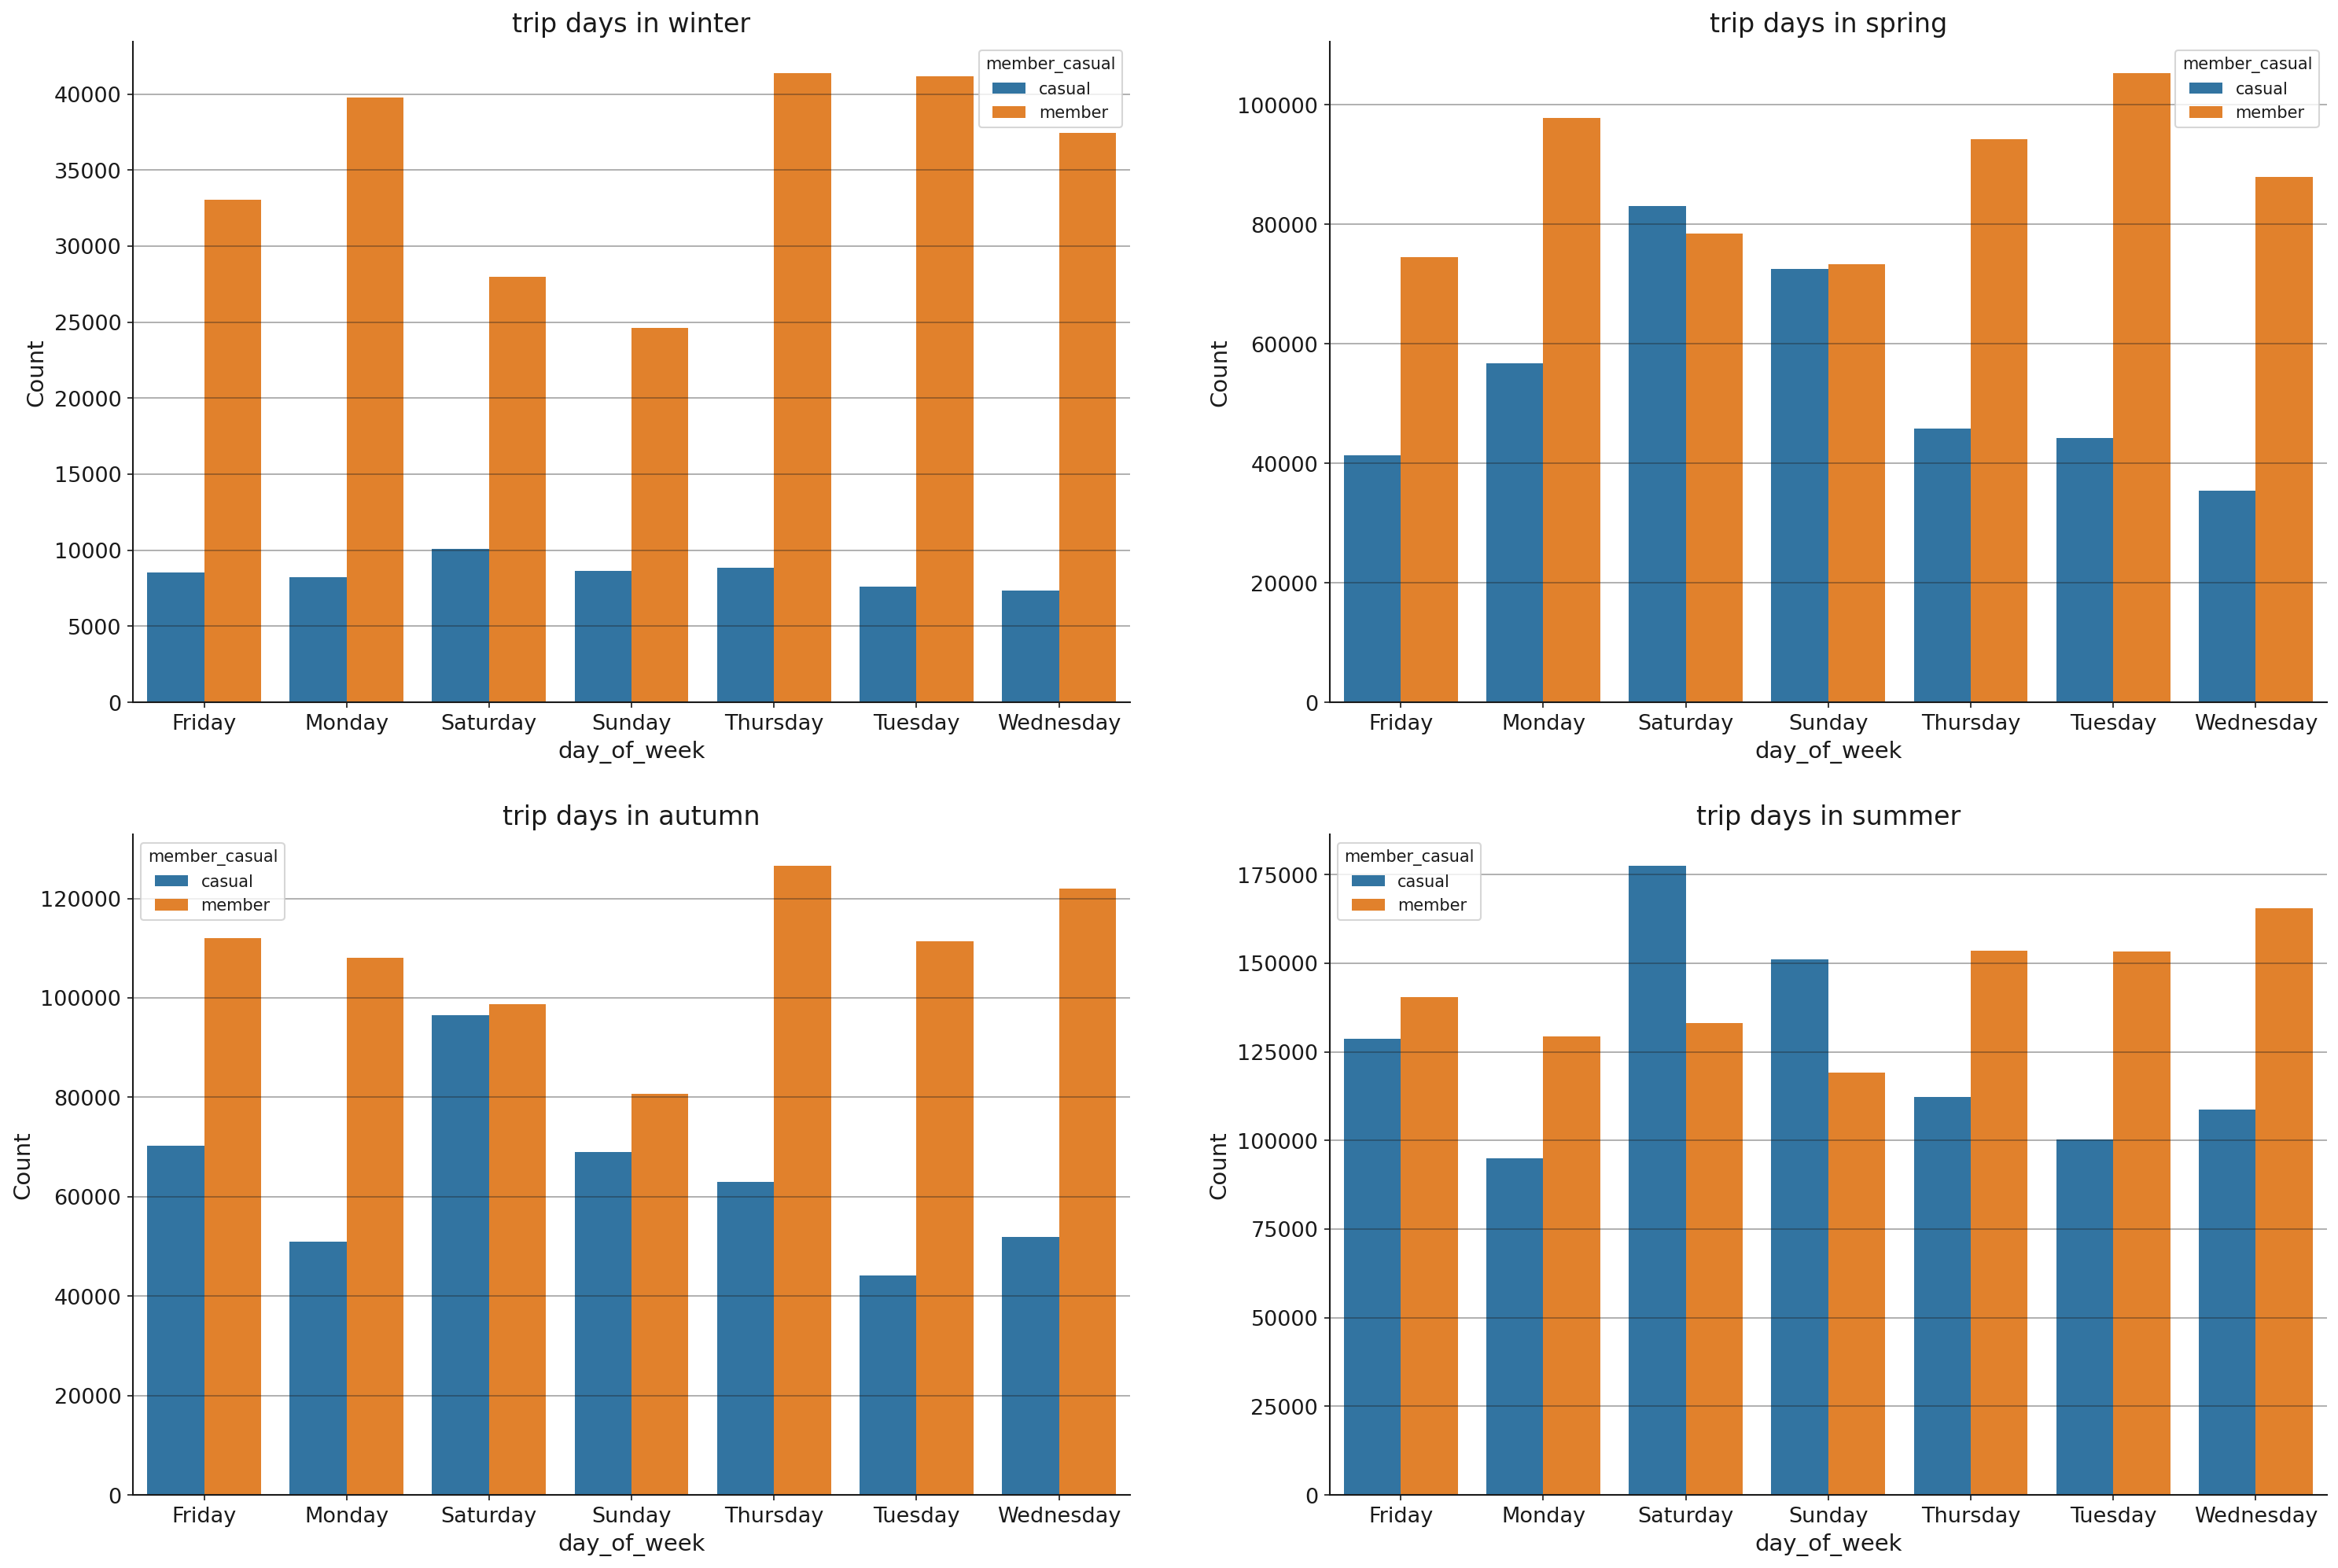

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("stylesheet.matplotlibrc")



fig, ax = plt.subplots(2,2,figsize=(24,16))
i=-1
for ax1,season in zip(ax.reshape(4,),seasons):
    data=season.groupby(["day_of_week","member_casual"]).count().reset_index()

    i+=1
    lst=["winter","spring","autumn","summer"]
    sns.barplot(data, x="day_of_week", y="ride_id", hue="member_casual", ax=ax1)
    ax1.set_title(f"trip days in {lst[i]}")
    ax1.set_ylabel("Count")


plt.show()

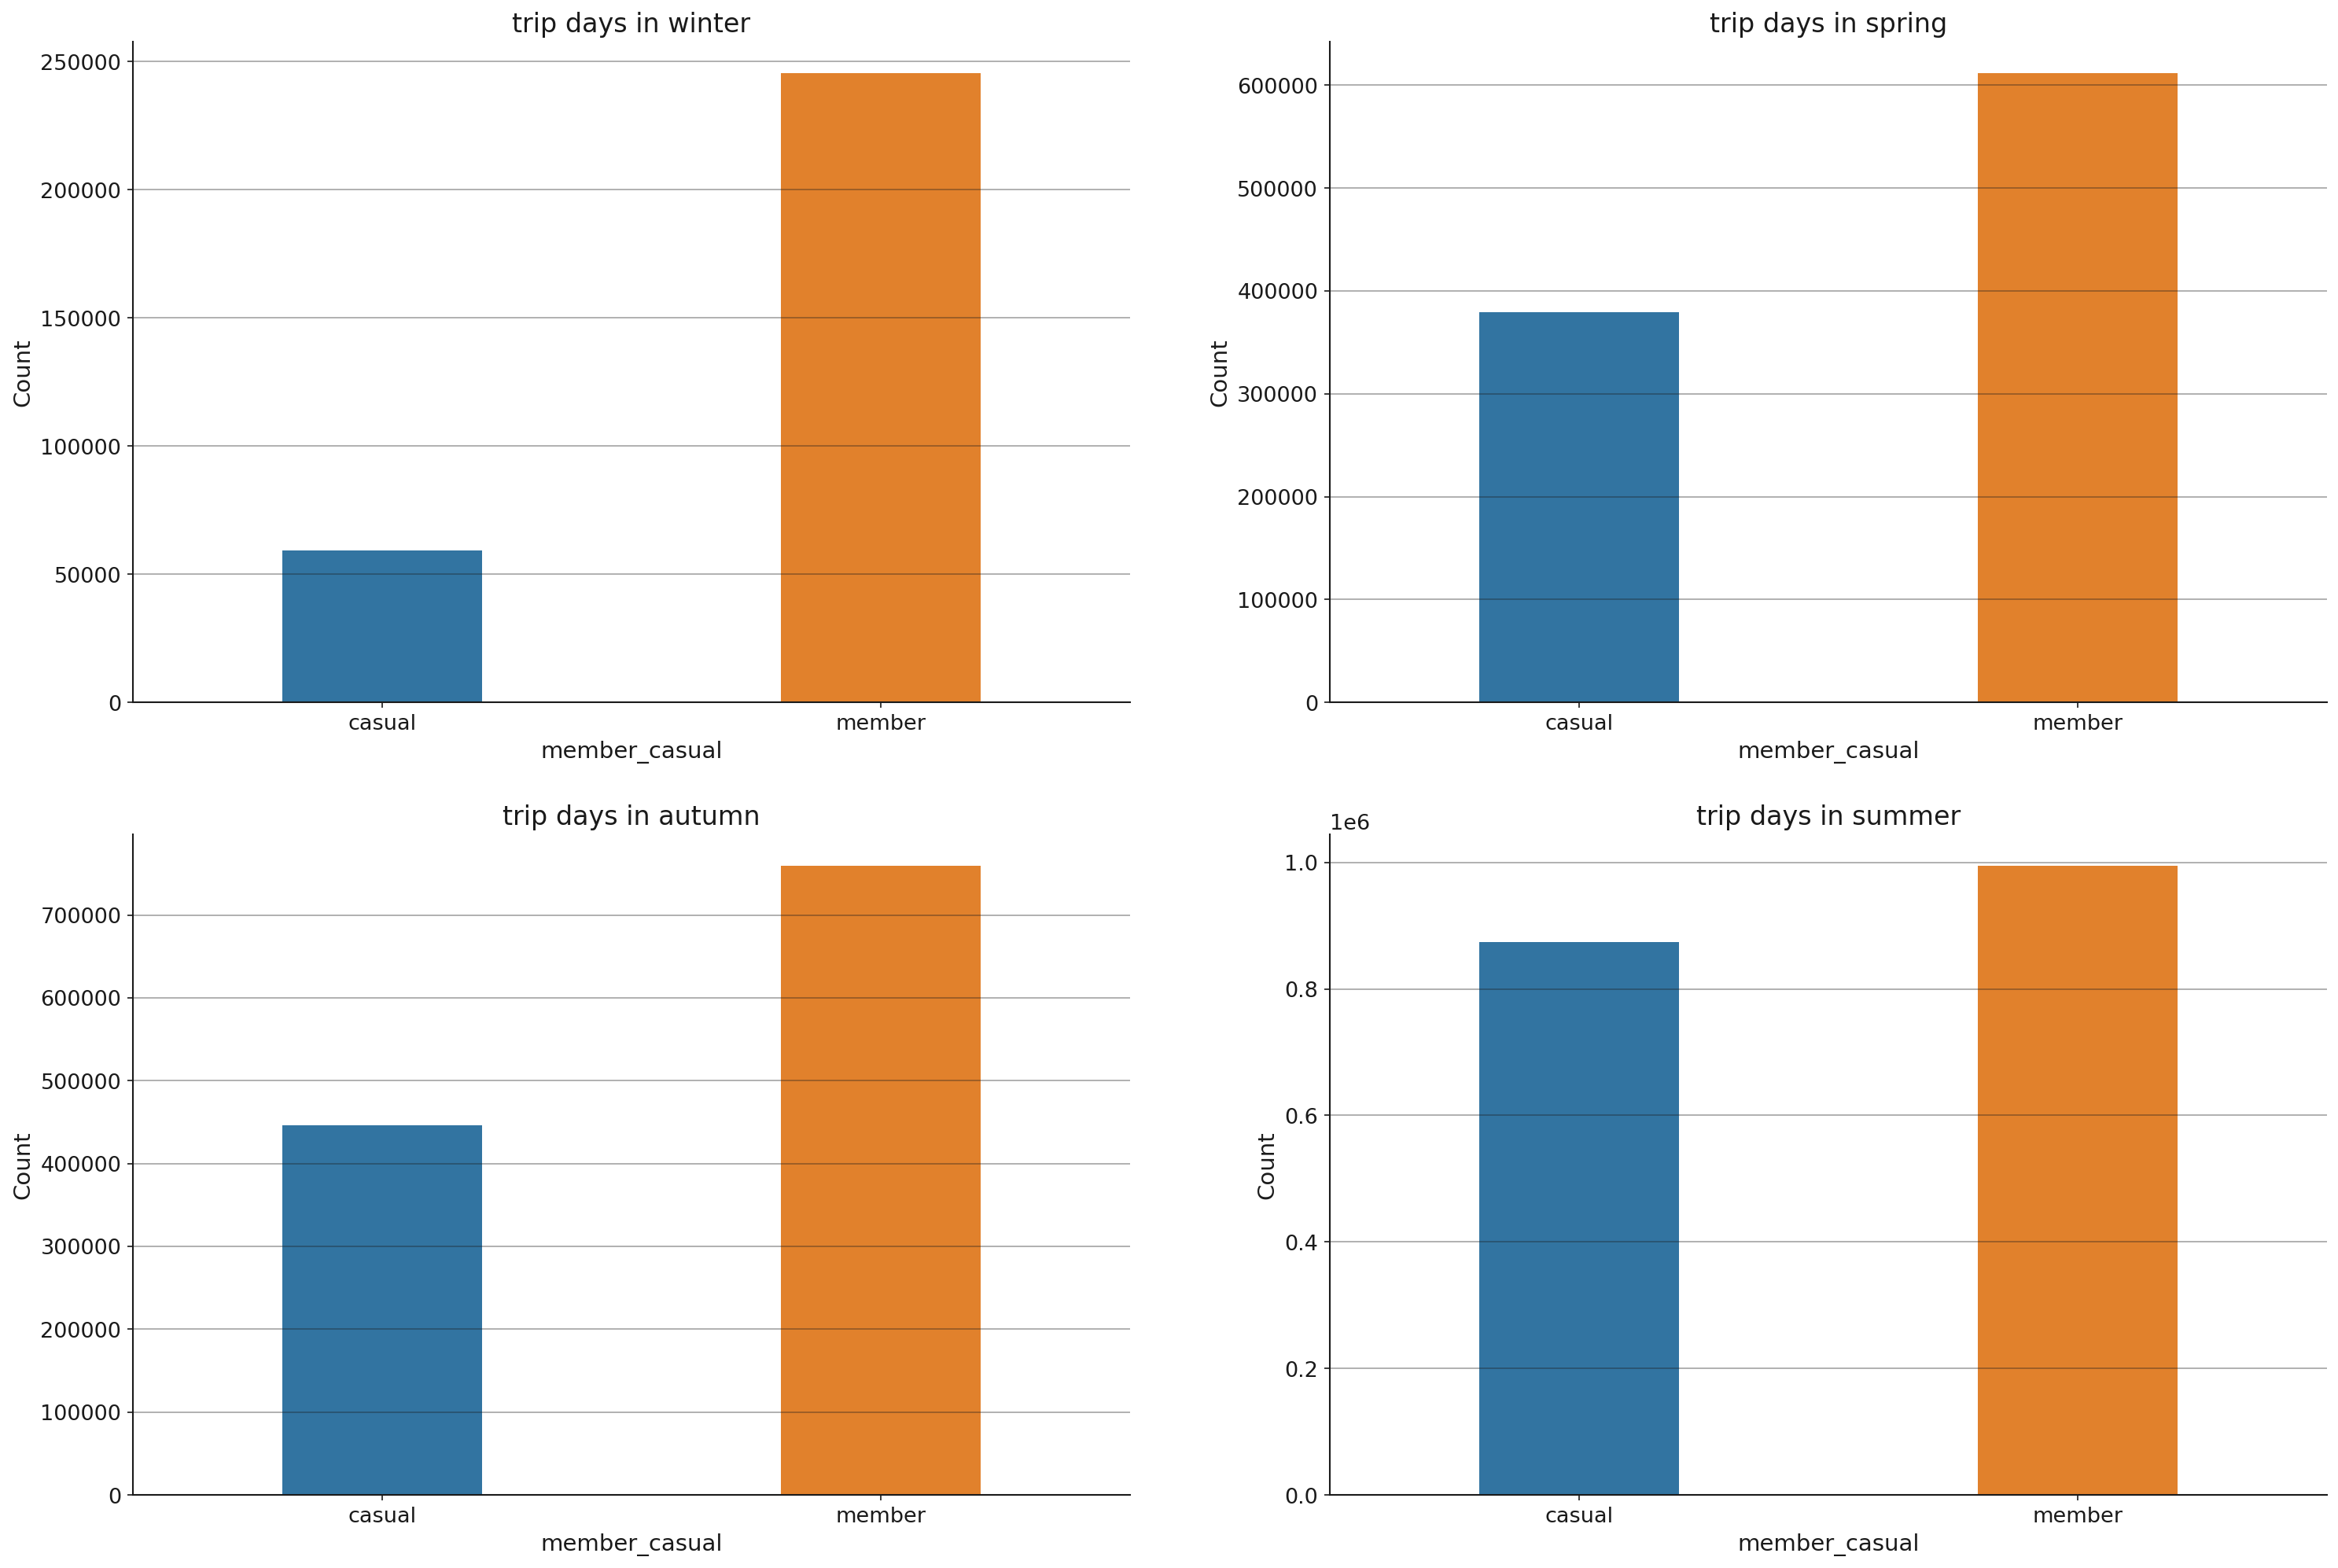

In [10]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("stylesheet.matplotlibrc")

seasons=[winter,spring,autumn,summer]

fig, ax = plt.subplots(2,2,figsize=(24,16))
i=-1
for ax1,season in zip(ax.reshape(4,),seasons):
    data=season.groupby("member_casual").count().reset_index()

    i+=1
    lst=["winter","spring","autumn","summer"]
    sns.barplot(data, x="member_casual", y="ride_id", ax=ax1,width=0.4)
    ax1.set_title(f"trip days in {lst[i]}")
    ax1.set_ylabel("Count")


plt.show()

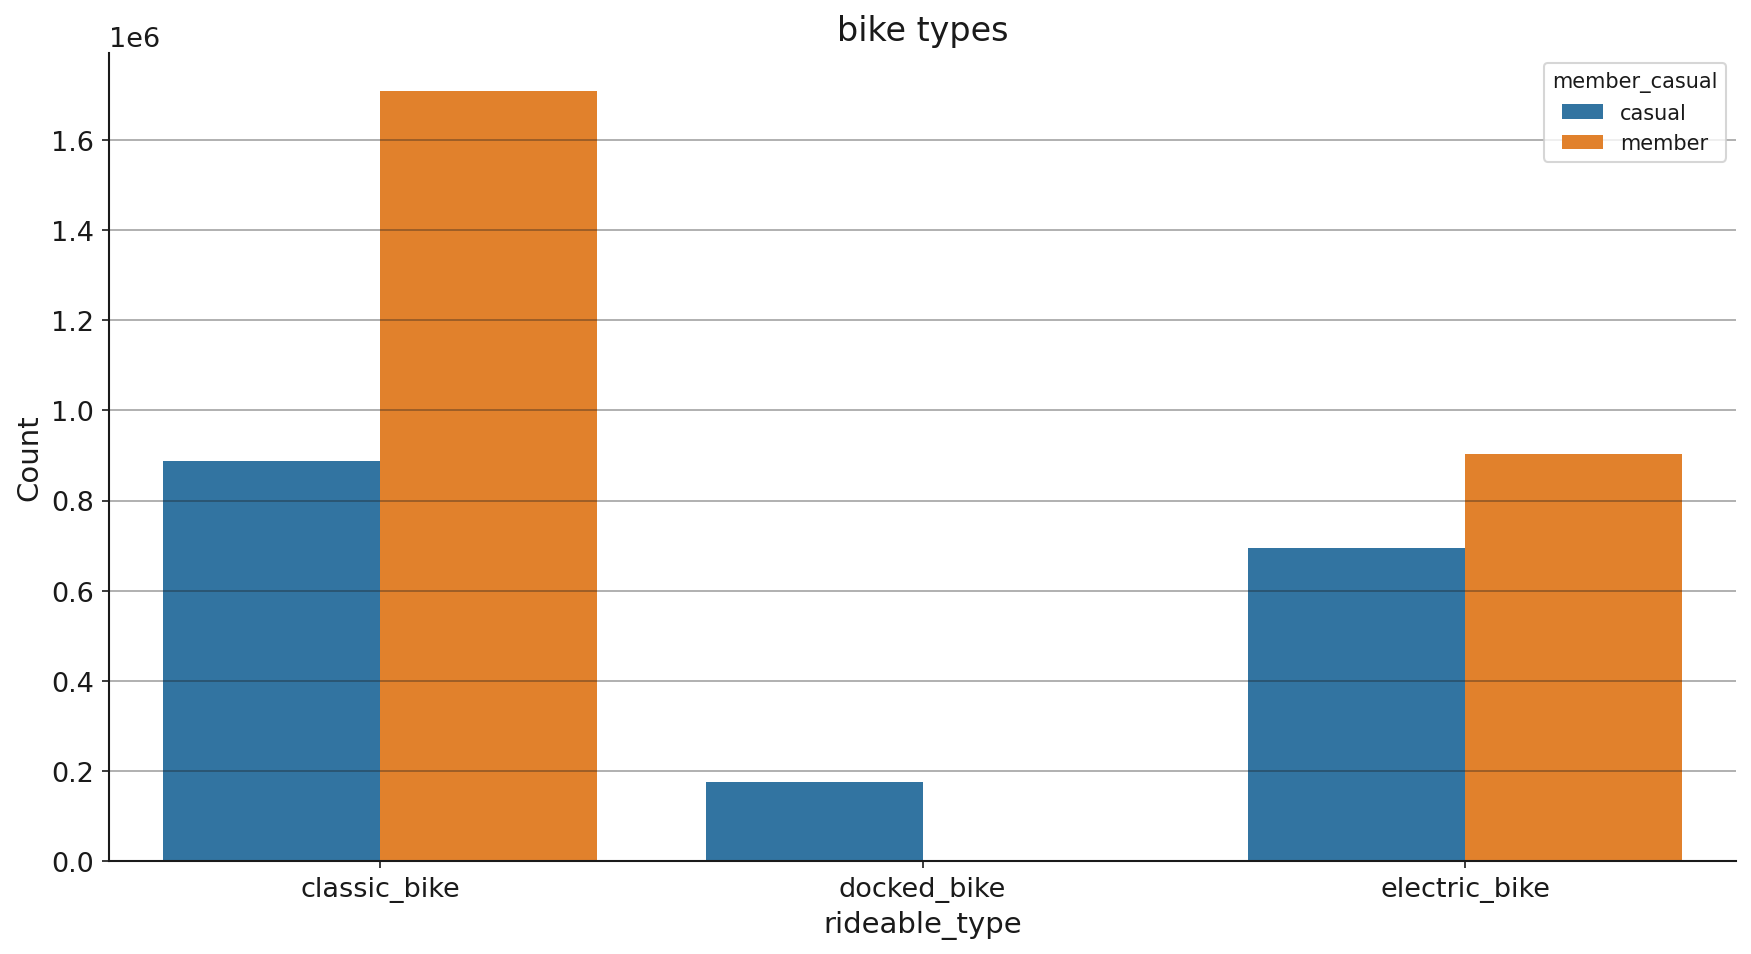

In [11]:
data=year.groupby(["rideable_type","member_casual"]).count().reset_index()


sns.barplot(data, x="rideable_type", y="ride_id", hue="member_casual")

plt.title("bike types")
plt.ylabel("Count")
plt.show()


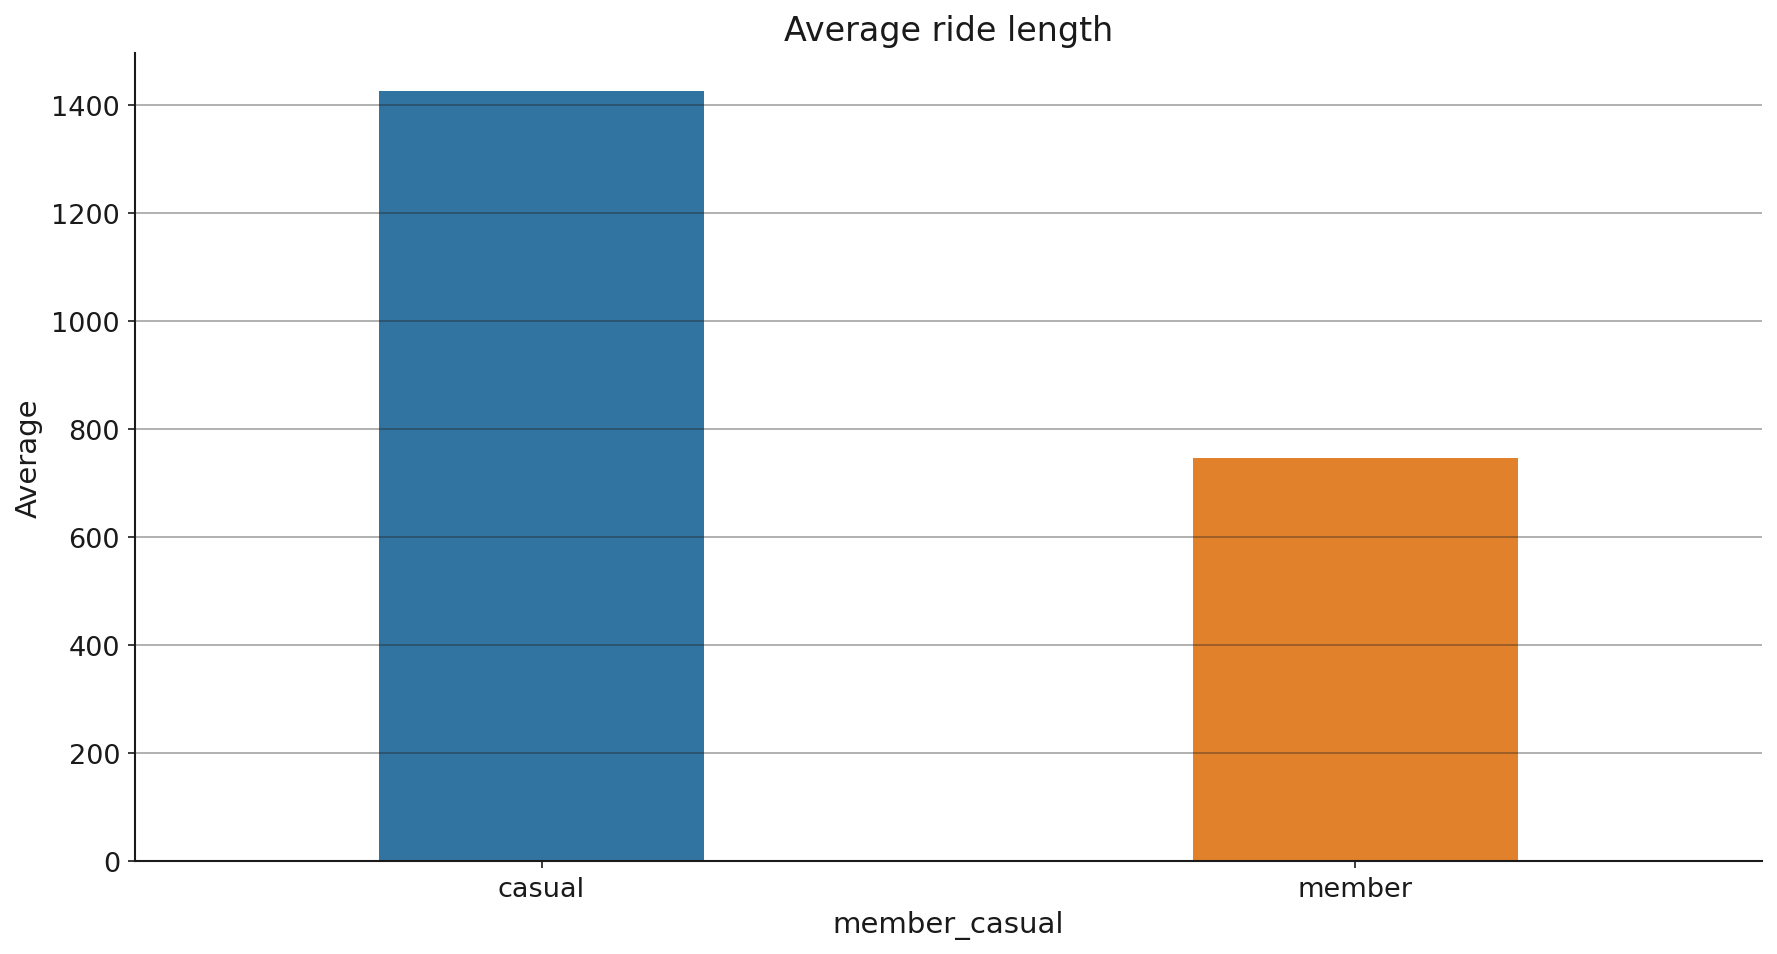

In [12]:
data=year.groupby("member_casual")["ride_length"].mean().reset_index()

sns.barplot(data, x="member_casual", y="ride_length",width=0.4)

plt.ylabel("Average")
plt.title("Average ride length")
plt.show()

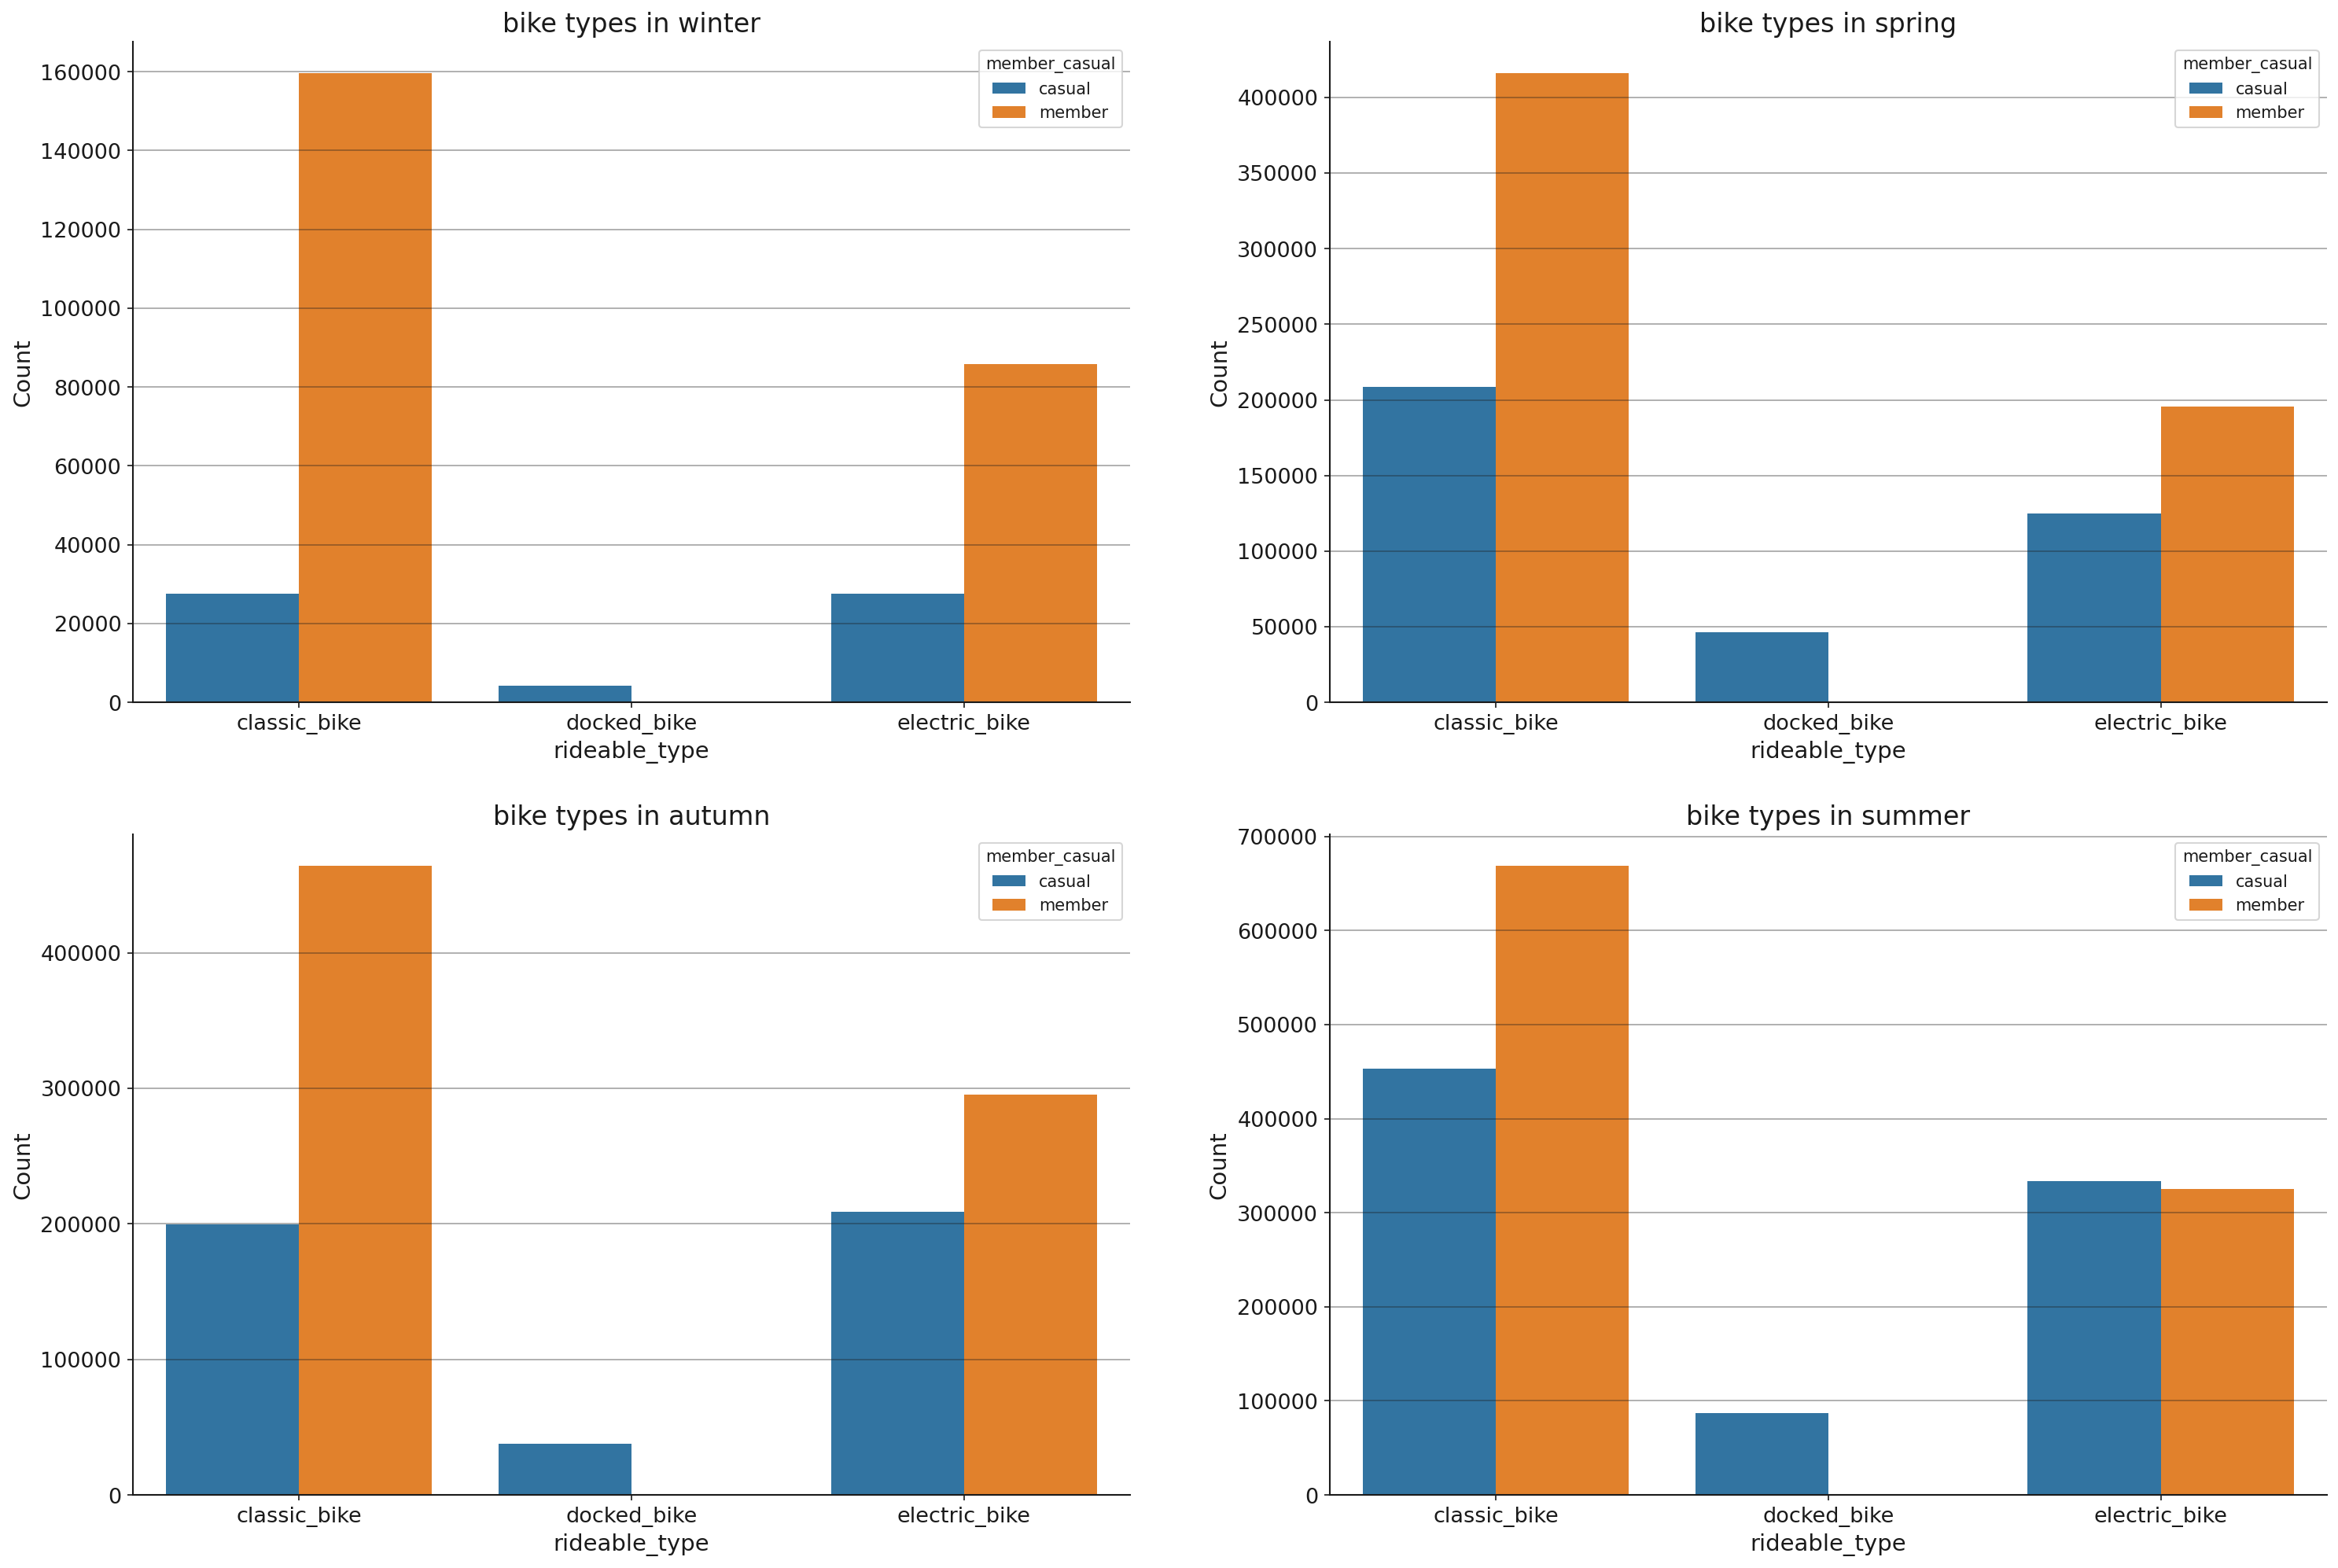

In [13]:
fig, ax = plt.subplots(2,2,figsize=(24,16))

year=pd.concat(seasons)

i=-1
for ax1,season in zip(ax.reshape(4,),seasons):
    data=season.groupby(["rideable_type","member_casual"]).count().reset_index()

    i+=1
    lst=["winter","spring","autumn","summer"]
    ax1.set_title(f"bike types in {lst[i]}")
    sns.barplot(data, x="rideable_type", y="ride_id", hue="member_casual", ax=ax1)
    ax1.set_ylabel("Count")
plt.show()

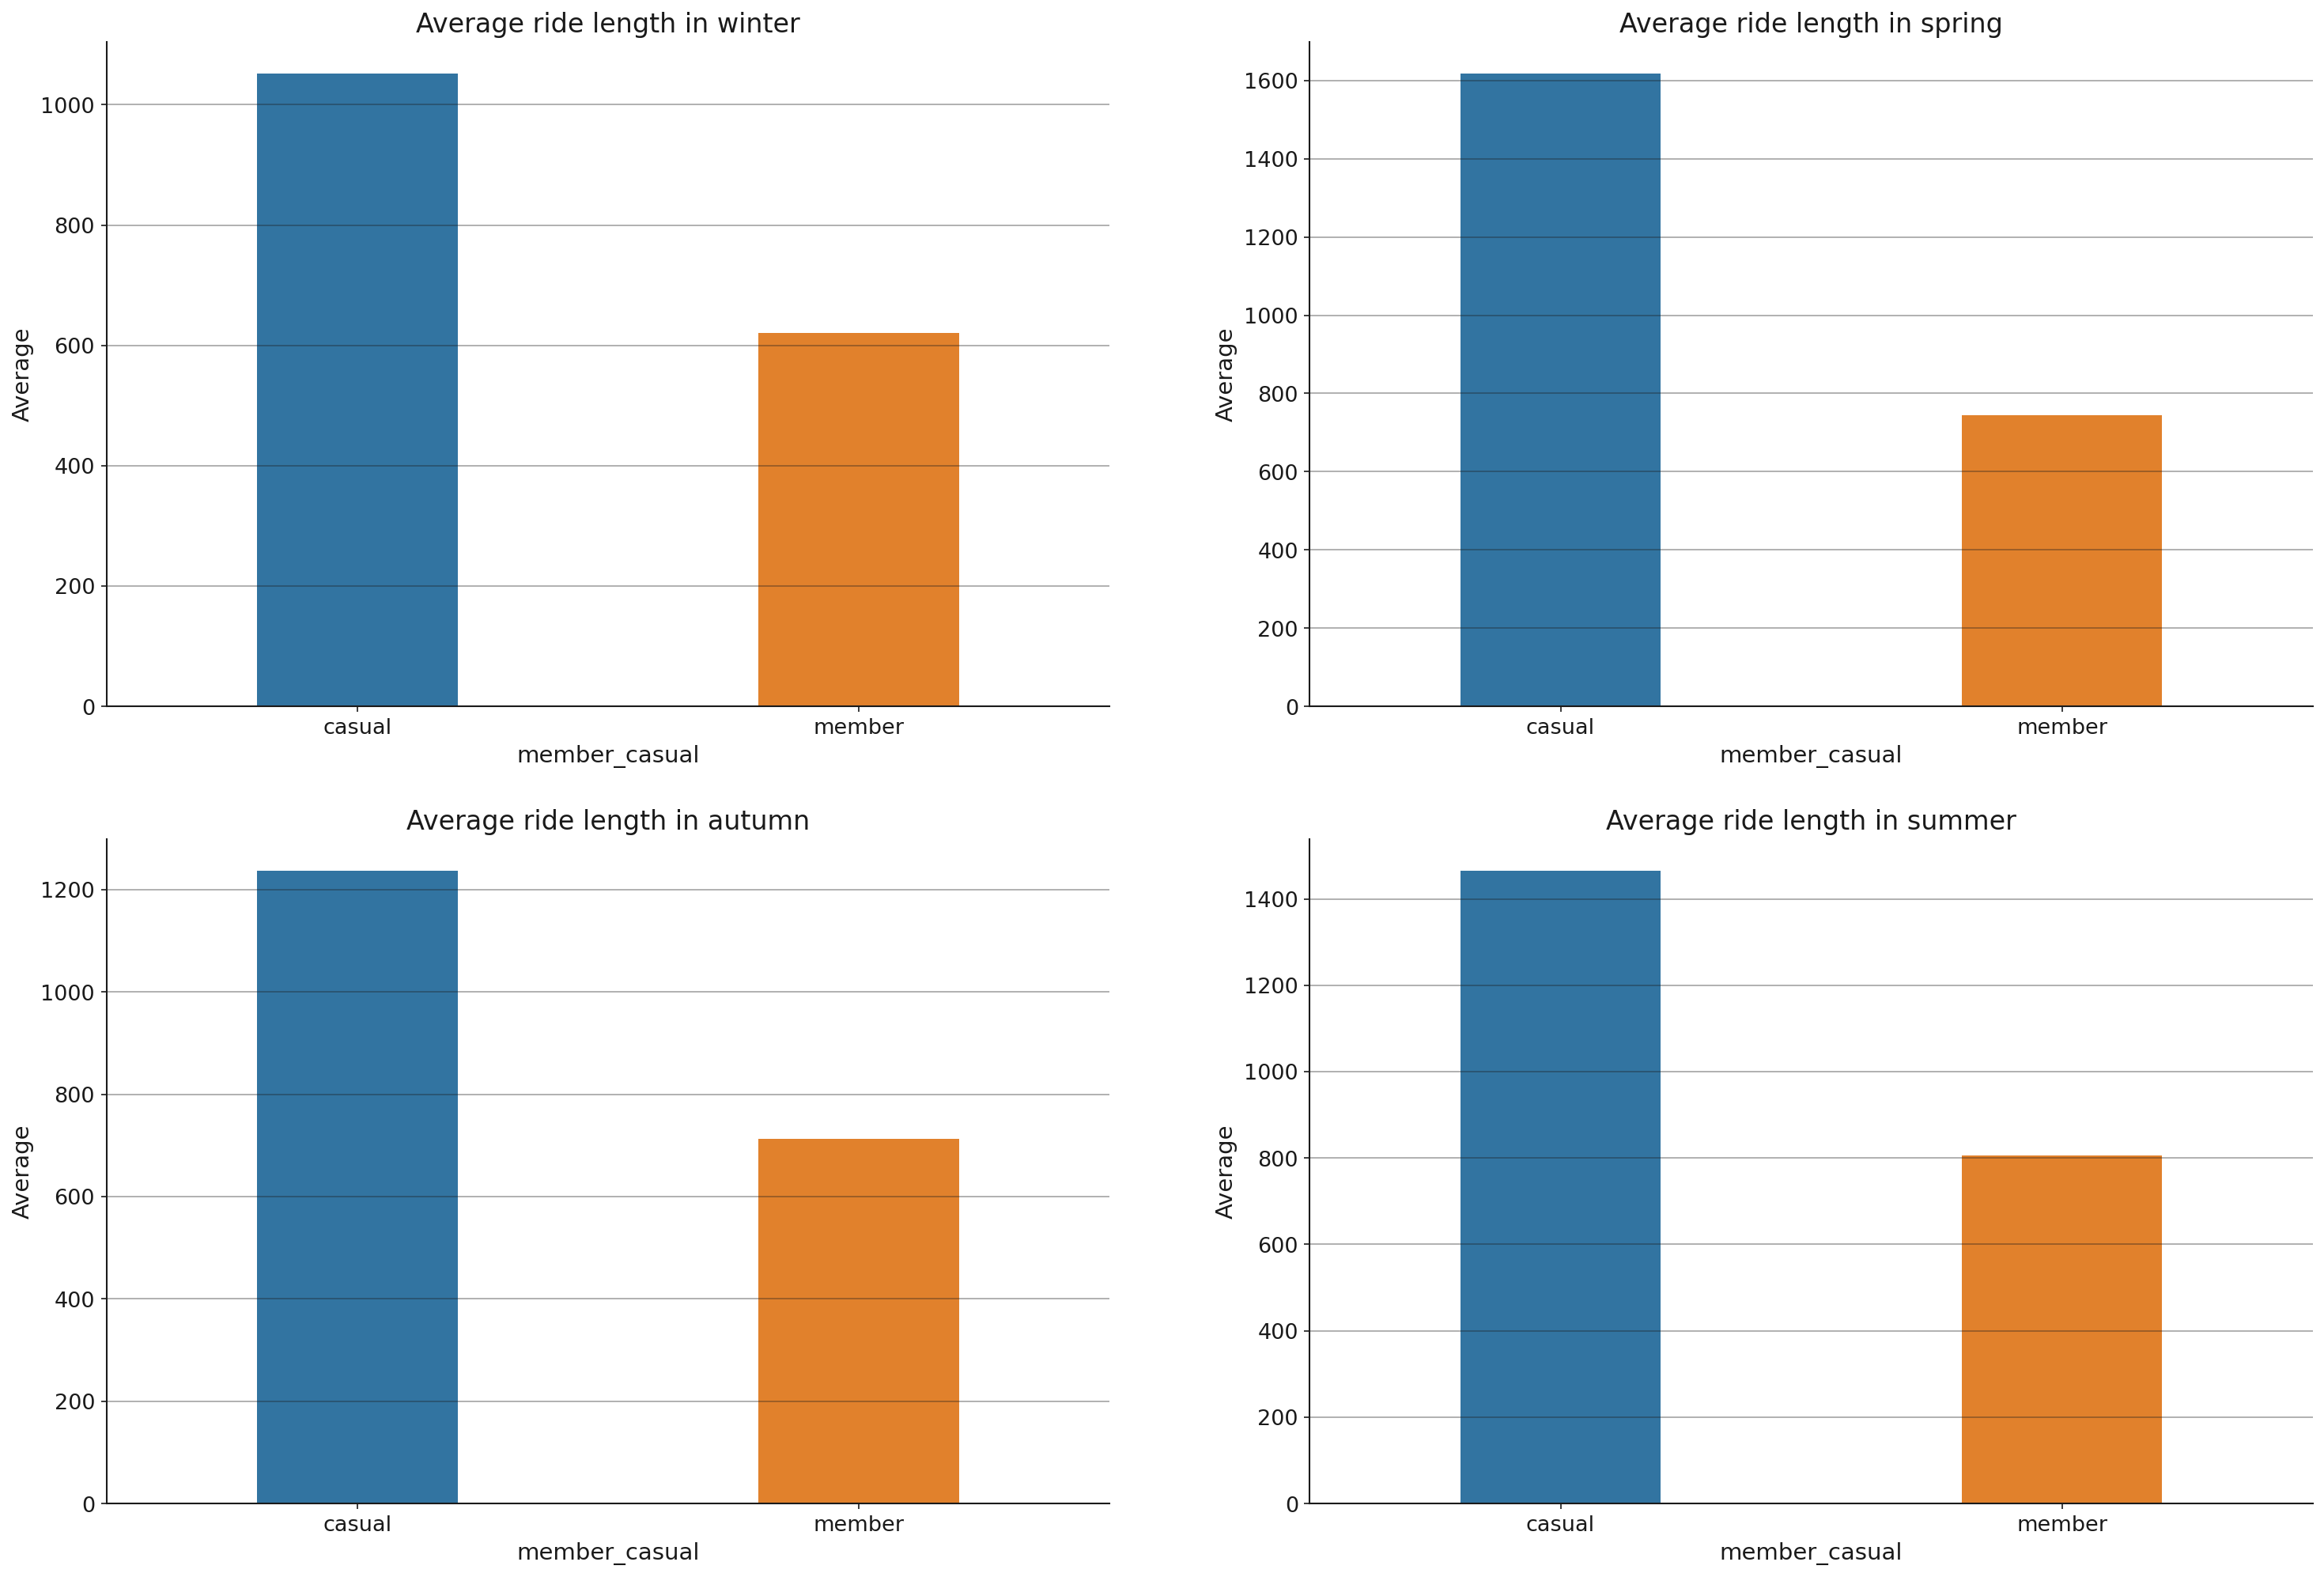

In [14]:
fig, ax = plt.subplots(2,2,figsize=(24,16))
i=-1
for ax1,season in zip(ax.reshape(4,),seasons):
    data=season.groupby("member_casual")["ride_length"].mean().reset_index()

    i+=1
    lst=["winter","spring","autumn","summer"]
    ax1.set_title(f"Average ride length in {lst[i]}")

    sns.barplot(data, x="member_casual", y="ride_length", ax=ax1,width=0.4)
    ax1.set_ylabel("Average")
plt.show()